In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
import xgboost as xgb

from tensorflow.keras.layers import Dense, Dropout,Activation
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Sequential

from sklearn.metrics import mean_squared_error, median_absolute_error,r2_score

import warnings
warnings.filterwarnings('ignore')

2024-05-19 08:38:48.982748: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 08:38:50.411450: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 08:38:50.411698: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 08:38:50.688384: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-19 08:38:51.289106: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 08:38:51.317578: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Reading Data

In [2]:
data=pd.read_csv('SolarPrediction.csv')

In [3]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [5]:
data.isna().sum()

UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64

# Data Wrangling

### We need to get the first part of the data, that is the date part from the data column

In [6]:
df=data.copy()

In [7]:
df['Data']=df['Data'].apply(lambda x:x.split()[0])

In [8]:
df['Month']=pd.to_datetime(df['Data']).dt.month

In [9]:
df['Day']=pd.to_datetime(df['Data']).dt.day
df['Hour']=pd.to_datetime(df['Time']).dt.hour
df['Minute']=pd.to_datetime(df['Time']).dt.minute
df['Second']=pd.to_datetime(df['Time']).dt.second

In [10]:
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00,12,1,0,20,4
32682,1480587301,12/1/2016,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00,12,1,0,15,1
32683,1480587001,12/1/2016,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00,12,1,0,10,1
32684,1480586702,12/1/2016,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00,12,1,0,5,2


#### Using regular expression inplace of Dateandtime function as above

In [11]:
df['risehour']=df['TimeSunRise'].apply(lambda x:re.search(r'^\d+',x).group(0)).astype(int)
df['riseminute'] = df['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [12]:
df['sethour']=df['TimeSunSet'].apply(lambda x:re.search(r'^\d+',x).group(0)).astype(int)
df['setminute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [13]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
 11  Month                   32686 non-null  int32  
 12  Day                     32686 non-null  int32  
 13  Hour                    32686 non-null  int32  
 14  Minute                  32686 non-null

In [15]:
df.drop(['UNIXTime','Data','Time','TimeSunRise','TimeSunSet'],axis=1,inplace=True)

In [16]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [17]:
input_features=df.drop(['Radiation'],axis=1)
target=df['Radiation']

In [18]:
input_features

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,44,30.43,102,145.42,6.75,12,1,0,20,4,6,41,17,42
32682,44,30.42,102,117.78,6.75,12,1,0,15,1,6,41,17,42
32683,44,30.42,102,145.19,9.00,12,1,0,10,1,6,41,17,42
32684,44,30.42,101,164.19,7.87,12,1,0,5,2,6,41,17,42


In [19]:
corr_matrx=df.corr()
corr_matrx

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


<Axes: >

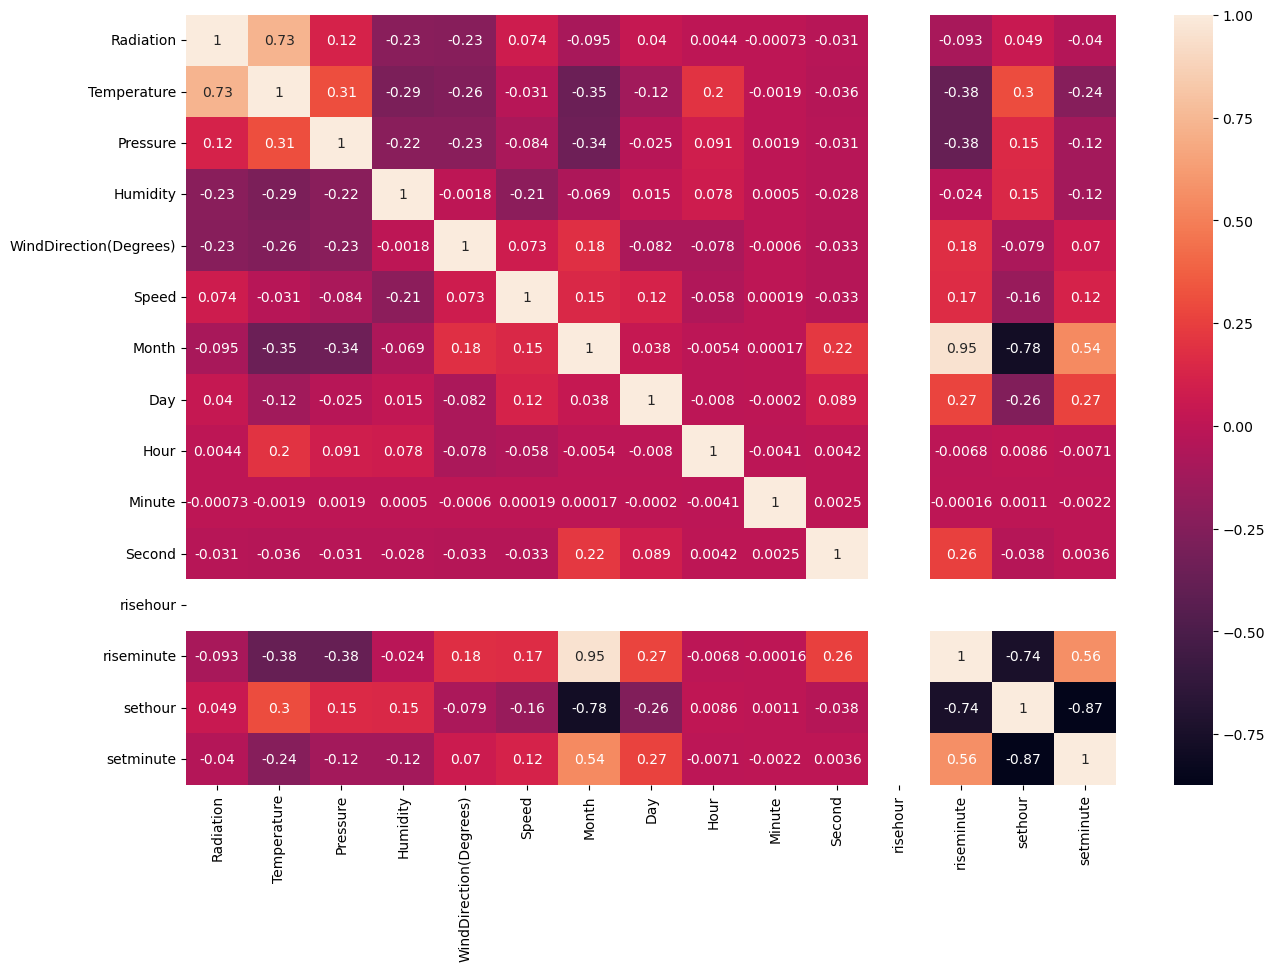

In [20]:
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrx,annot=True,linecolor='white')

### Select KBest Method

In [21]:
best_features=SelectKBest(score_func=chi2,k=10)

In [22]:
fit=best_features.fit(input_features,target)

ValueError: Unknown label type: (array([1.21, 1.21, 1.23, ..., 1.2 , 1.23, 1.2 ]),)

### As you can see above it shows label error and we need to convert the output to the label format meaning it should not be in float

##### The 1st method is to use LabelEncoder

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
a=LabelEncoder()
f=a.fit_transform(target)

In [25]:
f

array([ 9,  9, 11, ...,  8, 11,  8])

##### The 2nd method is to multiply the target by 100 which inturns converts to float

In [26]:
target1=target.apply(lambda x:int(x*100))

In [27]:
target1

0        121
1        121
2        123
3        121
4        117
        ... 
32681    122
32682    117
32683    120
32684    123
32685    120
Name: Radiation, Length: 32686, dtype: int64

##### Now let us standarize the input variables in order to avoid bias

In [28]:
from sklearn.preprocessing import MinMaxScaler
inputfeatures=MinMaxScaler()
scaled_x=inputfeatures.fit_transform(input_features)

##### Now we have our scaled x as well as label output, just need to apply in select K Best method

In [29]:
fit=best_features.fit(scaled_x,target1)

In [30]:
scores=pd.DataFrame(fit.scores_)
columns=pd.DataFrame(input_features.columns)

In [31]:
features_scores=pd.concat([columns,scores],axis=1)

In [32]:
features_scores.columns=['Features','feature_imp']

In [33]:
features_scores.sort_values(by='feature_imp',inplace=True,ascending=False)

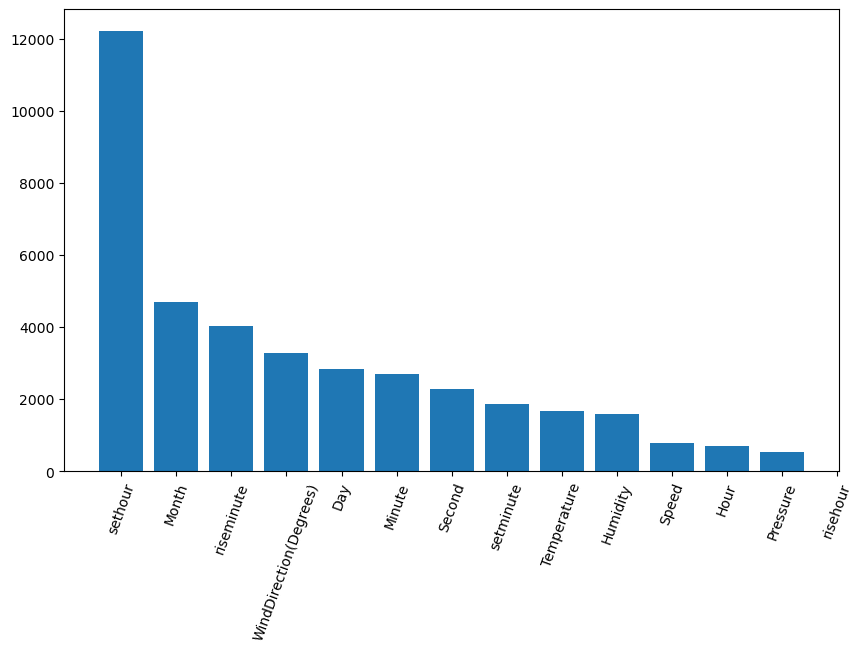

In [34]:
plt.figure(figsize=(10,6))
plt.bar(features_scores.Features,features_scores.feature_imp)
plt.xticks(rotation=70)
plt.show()

## Feature Selection using Extra Tree Classifier

In [35]:
model=ExtraTreesClassifier(n_estimators=10)

In [36]:
model.fit(scaled_x,target1)

ExtraTreesClassifier(n_estimators=10)

In [37]:
feature_importances=pd.DataFrame(model.feature_importances_,index=input_features.columns,columns=['feature_importance'])
feature_importances.sort_values(by='feature_importance',inplace=True,ascending=False)
feature_importances

,feature_importance
WindDirection(Degrees),0.156801
Minute,0.148554
Speed,0.125095
Second,0.122527
Humidity,0.109712
Hour,0.090996
Temperature,0.083137
Pressure,0.077622
Day,0.034890
setminute,0.024070


### Feature Enginneering using BoxCox,Log,MinMax and Standard Transformation

100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


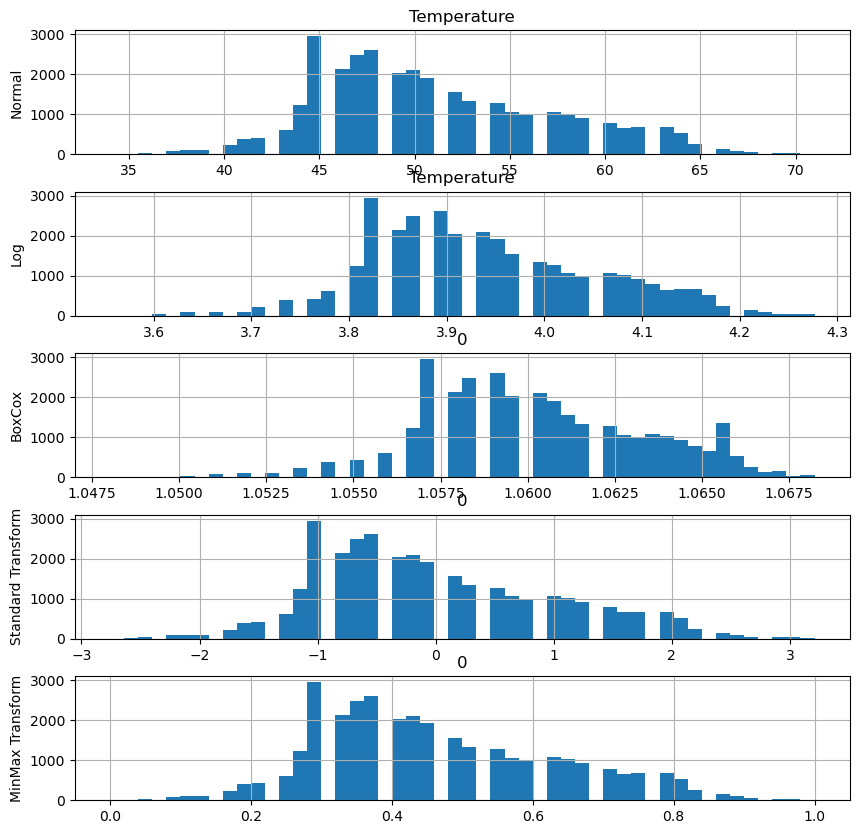

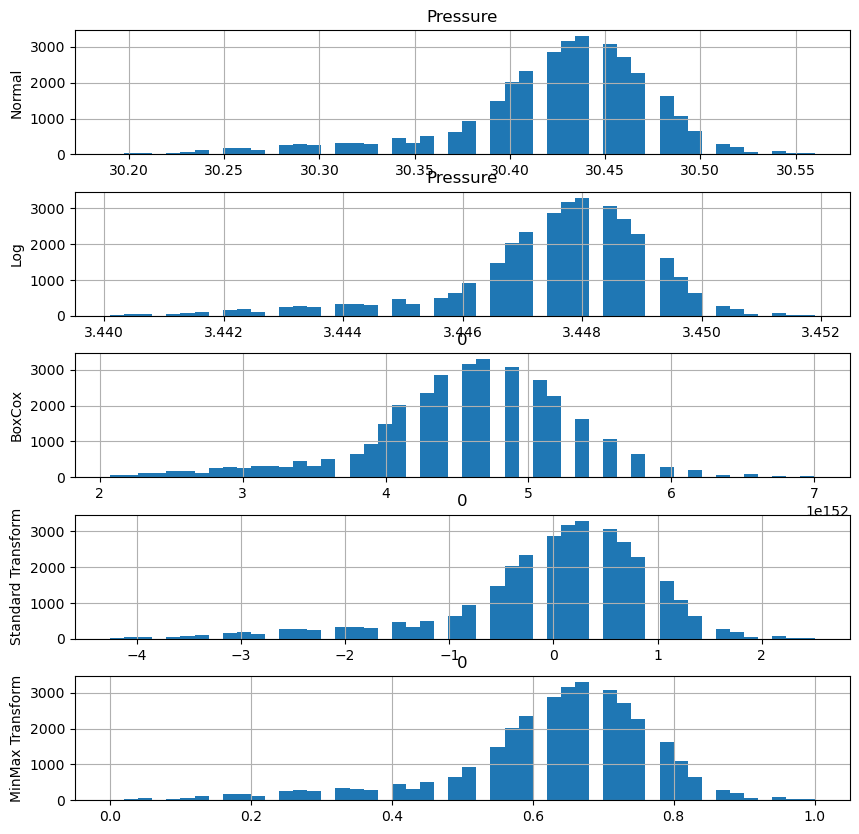

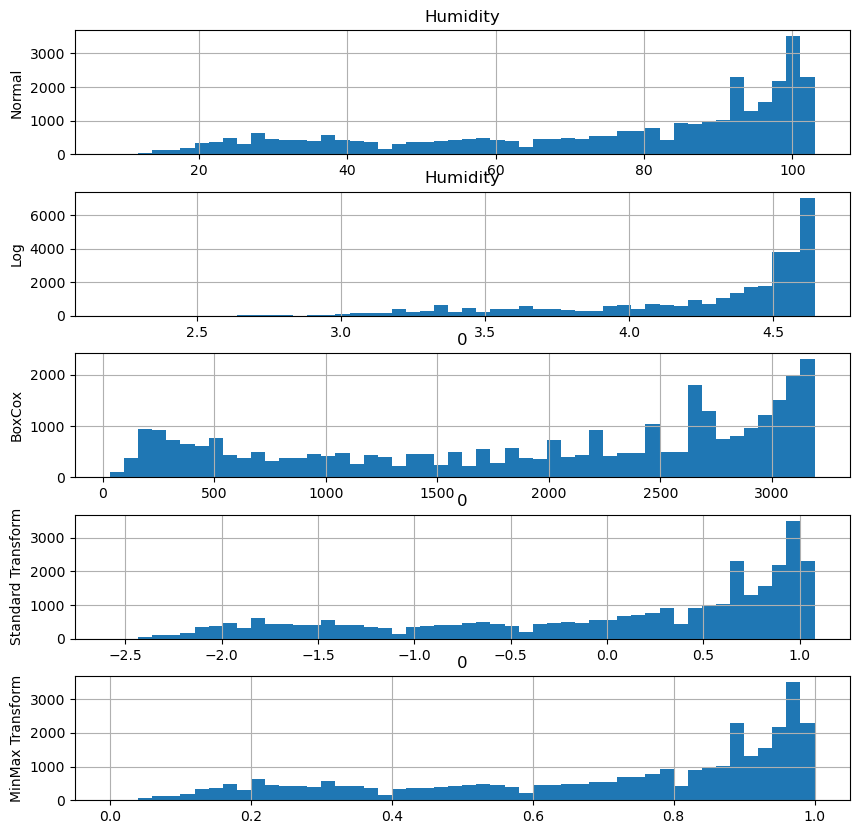

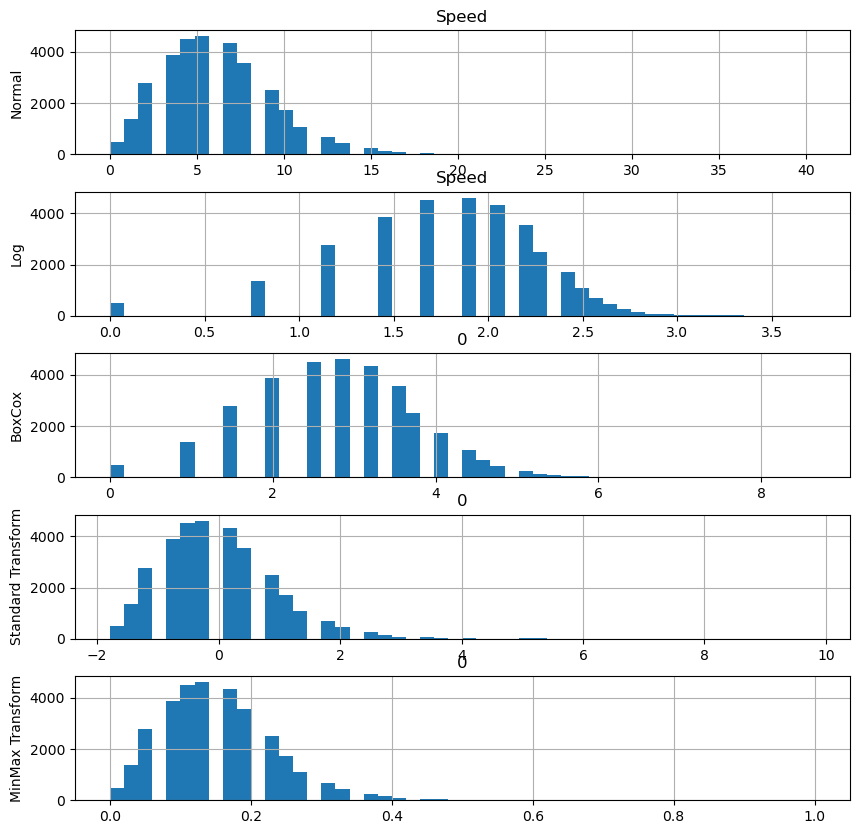

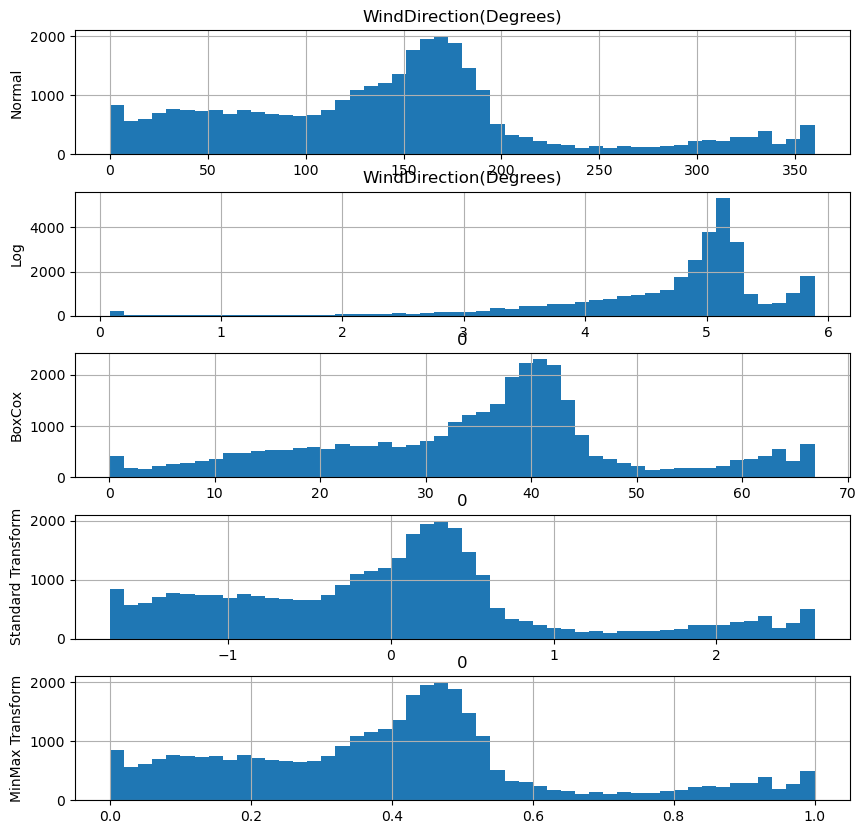

In [38]:
features_to_transform=['Temperature','Pressure','Humidity','Speed','WindDirection(Degrees)']
from tqdm import tqdm
for i in tqdm(features_to_transform):
    fig,(ax1,ax2,ax3,ax4,ax5)=plt.subplots(5,1,figsize=(10,10))
    
    pd.DataFrame(input_features[i]).hist(ax=ax1,bins=50)
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax=ax2,bins=50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax=ax3,bins=50)
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1,1))).hist(ax=ax4,bins=50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1,1))).hist(ax=ax5,bins=50)
    
    ax1.set_ylabel("Normal")
    ax2.set_ylabel('Log')
    ax3.set_ylabel('BoxCox')
    ax4.set_ylabel('Standard Transform')
    ax5.set_ylabel('MinMax Transform')
    
    

In [39]:
print("Before Transformation done")
input_features.head()

Before Transformation done


,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [40]:
transform={'Temperature':(input_features['Temperature']+1).transform(np.log),
           'Pressure':stats.boxcox(input_features['Pressure']+1)[0],
           'Humidity':stats.boxcox(input_features['Humidity']+1)[0],
           'Speed':(input_features['Speed']+1).transform(np.log),
           'WindDirection(Degrees)':(MinMaxScaler().fit_transform(np.array(input_features['WindDirection(Degrees)']).reshape(-1,1)))}

In [41]:
for i in transform:
    input_features[i]=transform[i]

In [42]:
print("After Transformation")
input_features 

After Transformation


,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,3.891820,5.044903e+152,1139.358550,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.891820,5.044903e+152,1104.046869,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.891820,5.044903e+152,1069.253439,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.891820,5.044903e+152,1175.187370,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.891820,5.044903e+152,1248.392086,0.291391,1.890095,9,29,23,35,24,6,13,18,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,3.806662,4.571431e+152,3134.682402,0.403851,2.047693,12,1,0,20,4,6,41,17,42
32682,3.806662,4.423604e+152,3134.682402,0.327044,2.047693,12,1,0,15,1,6,41,17,42
32683,3.806662,4.423604e+152,3134.682402,0.403212,2.302585,12,1,0,10,1,6,41,17,42
32684,3.806662,4.423604e+152,3077.932765,0.456011,2.182675,12,1,0,5,2,6,41,17,42


In [44]:
x_train,x_test,y_train,y_test=train_test_split(input_features,target,random_state=1,test_size=0.2)

In [45]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)

In [48]:
x_train.shape,x_test.shape

((26148, 14), (6538, 14))

## XGBoost

In [52]:
from xgboost import XGBRegressor

params={
    'learning_rate':0.1,
    'max_depth':8
}
model=XGBRegressor(**params)

In [53]:
model.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [55]:
predict=model.predict(x_test)

In [58]:
rmse=np.sqrt(mean_squared_error(y_test,predict))
r2=r2_score(y_test,predict)

In [59]:
rmse,r2

(121.52553737443313, 0.8483869133160818)

## MultiLayer Preceptron

In [62]:
model=None
model=Sequential()

model.add(Dense(128,activation='relu',input_dim=14))
model.add(Dropout(0.33))


model.add(Dense(128,activation='relu',input_dim=14))
model.add(Dropout(0.33))

model.add(Dense(128,activation='relu',input_dim=14))
model.add(Dropout(0.33))

model.add(Dense(128,activation='relu',input_dim=14))
model.add(Dropout(0.33))

model.add(Dense(1,activation='relu'))

model.compile(metrics='mse',loss='mse',optimizer=Adam(learning_rate=0.001))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               1920      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 128)              

In [63]:
history=model.fit(x_train,y_train,validation_split=0.1,epochs=50,batch_size=32)

Epoch 1/50


2024-05-19 09:09:15.578624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type CPU is enabled.


736/736 [==============================] - 4s 3ms/step - loss: 42265.0703 - mse: 42265.0703 - val_loss: 22029.4531 - val_mse: 22029.4531
Epoch 2/50
736/736 [==============================] - 2s 3ms/step - loss: 25227.5781 - mse: 25227.5781 - val_loss: 16321.8770 - val_mse: 16321.8770
Epoch 3/50
736/736 [==============================] - 2s 3ms/step - loss: 21101.0938 - mse: 21101.0938 - val_loss: 14501.3047 - val_mse: 14501.3047
Epoch 4/50
736/736 [==============================] - 2s 3ms/step - loss: 18550.3809 - mse: 18550.3809 - val_loss: 12394.9717 - val_mse: 12394.9717
Epoch 5/50
736/736 [==============================] - 2s 3ms/step - loss: 17076.9766 - mse: 17076.9766 - val_loss: 11964.5693 - val_mse: 11964.5693
Epoch 6/50
736/736 [==============================] - 2s 3ms/step - loss: 16022.2256 - mse: 16022.2256 - val_loss: 11239.3467 - val_mse: 11239.3467
Epoch 7/50
736/736 [==============================] - 2s 3ms/step - loss: 15613.6846 - mse: 15613.6846 - val_loss: 10639.96

In [65]:
predict1=model.predict(x_test)

205/205 [==============================] - 0s 2ms/step


In [66]:
a=mean_squared_error(y_test,predict)

In [67]:
a

14768.456234144742